Доделать распределение глобального изменения температуры, начиная с 1840 года

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm import tqdm_notebook

import pandas as pd
import warnings
import numpy as np
import math
import geoplot
import geopandas
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

In [253]:
def get_coords(city_names):
    points = pd.DataFrame(columns=['lat', 'lon'])
    cities_coords = city.groupby('City')[['Latitude', 'Longitude']].first()
    for city_ in tqdm_notebook(city_names):
        coords = cities_coords.loc[city_]
        lat = float(coords[0][:-1]) * (-1 if coords[0][-1] == 'S' else 1)
        lon = float(coords[1][:-1]) * (-1 if coords[1][-1] == 'W' else 1)
        
        
        points.loc[city_, 'lat'] = lat
        points.loc[city_, 'lon'] = lon
            
    return points  

def get_lon(lon):
    return float(lon[:-1]) * (-1 if lon[-1] == 'W' else 1)

def get_lat(lat):
    return float(lat[:-1]) * (-1 if lat[-1] == 'S' else 1)            

In [5]:
temperature = pd.read_csv('data/GlobalTemperatures.csv')
city = pd.read_csv('data/GlobalLandTemperaturesByCity.csv')
country = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv')
majorCity = pd.read_csv('data/GlobalLandTemperaturesByMajorCity.csv')
cityByState = pd.read_csv('data/GlobalLandTemperaturesByState.csv')

country['AverageTemperature_nan'] = country['AverageTemperature'].isnull()
country['dt'] = country['dt'].apply(lambda row: datetime.strptime(row, '%Y-%m-%d'))
temperature['dt'] = temperature['dt'].apply(lambda row: datetime.strptime(row, '%Y-%m-%d'))
majorCity['dt'] = majorCity['dt'].apply(lambda row: datetime.strptime(row, '%Y-%m-%d'))
city['dt'] = city['dt'].apply(lambda row: datetime.strptime(row, '%Y-%m-%d'))
cityByState['dt'] = cityByState['dt'].apply(lambda row: datetime.strptime(row, '%Y-%m-%d'))
country_names = np.sort(country['Country'].unique())

percents_nan = (country.groupby('Country')['AverageTemperature_nan'].sum().sort_index() / country.groupby('Country')['AverageTemperature_nan'].count().sort_index()).drop('Antarctica')
country_names = country_names[country_names != 'Antarctica']
russian_cities_names = city[city['Country'] == 'Russia']['City'].unique()
cities_names = city['City'].unique()
city_coords = get_coords(sorted(cities_names))
city['lat'] = city['Latitude'].apply(get_lat)
city['lon'] = city['Longitude'].apply(get_lon)
city = city.drop('Latitude', axis=1)
city = city.drop('Longitude', axis=1);

Прежде всего, после получения данных, хочется взглянуть на то, как ведёт себя температура на Земле. Для этого построим график зависимости температуры поверхности от месяца. Легко предположить, что получится каша, так как данных слишком много. Но для чистоты эксперимента, отрисуем

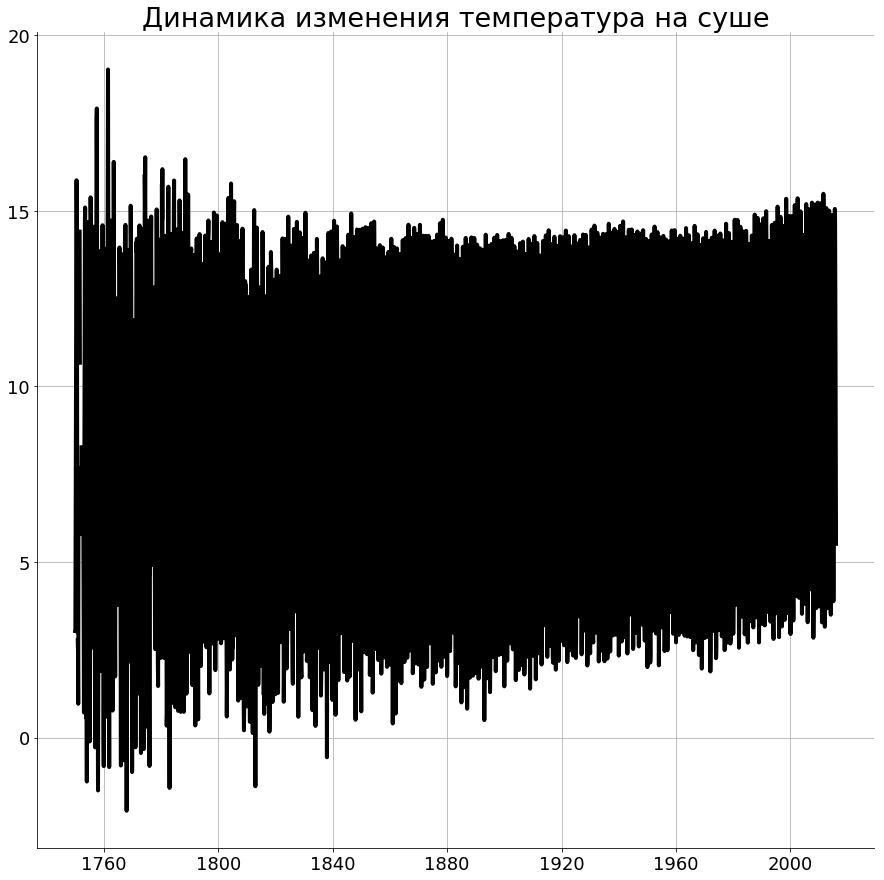

In [129]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
fontsize = 18
roll_step = 1
x = temperature['dt']
y = temperature['LandAverageTemperature'].rolling(roll_step, min_periods=1, center=True).mean()
plt.plot(x, y, linewidth=4, color=colors[month])
plt.title('Динамика изменения температура на суше', fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Теперь сделаем глаживание. На этом графике есть несколько особенностей. 

* Несколько впадин
* Несколько пиков
* Растущая температура
* Осцилляция в 2010-х годах (связана со способом обработки данных `rolling()`)
* Большая волотильность (до 1840 года)
* Цикличность (с большим периодом) в температуре с заметным трендом (до 1920 года)
* Цикличность (с маленьким периодом) в температуре

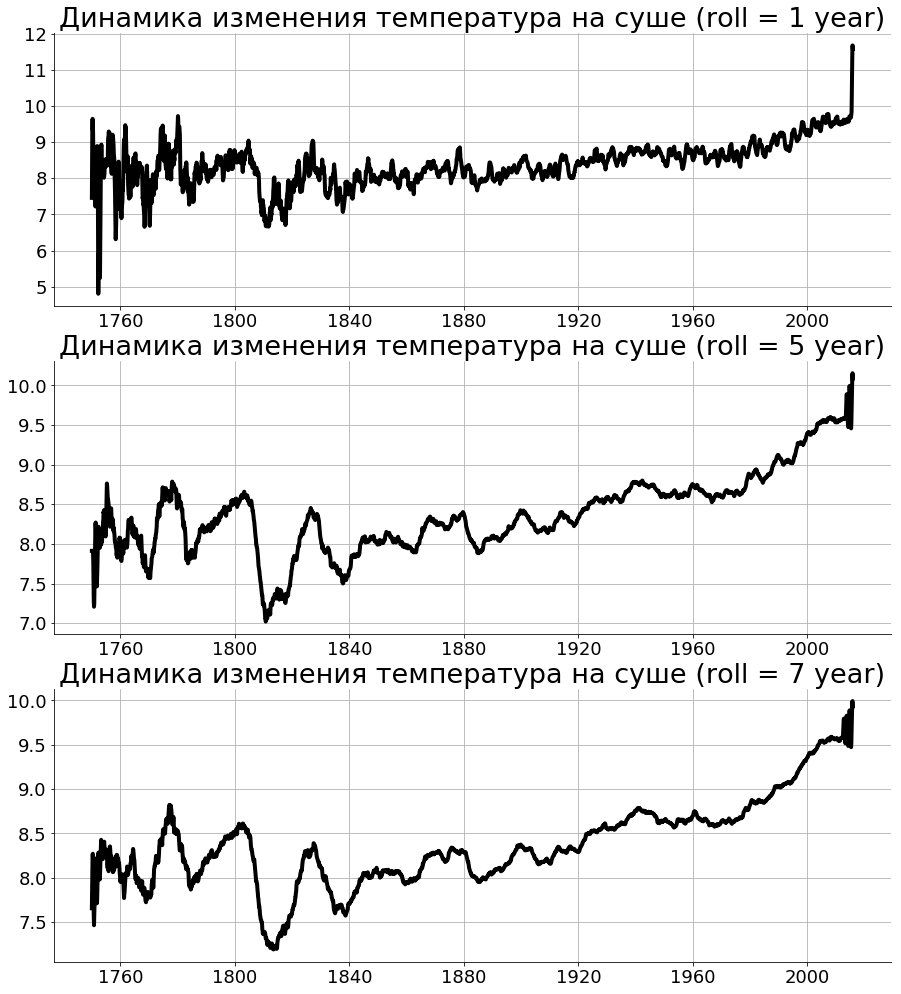

In [240]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(top=1.2)
ax = plt.subplot(311)
fontsize = 18
roll_step = 12


x = temperature['dt']
y = temperature['LandAverageTemperature'].rolling(roll_step, min_periods=1, center=True).mean()
y_conf = temperature['LandAverageTemperatureUncertainty'].rolling(roll_step, min_periods=1, center=True).mean()
plt.plot(x, y, linewidth=4, color='k')
plt.title('Динамика изменения температура на суше (roll = 1 year)', fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = plt.subplot(312)
y = temperature['LandAverageTemperature'].rolling(roll_step * 5, min_periods=1, center=True).mean()
plt.plot(x, y, linewidth=4, color='k')
plt.title('Динамика изменения температура на суше (roll = 5 year)', fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = plt.subplot(313)
y = temperature['LandAverageTemperature'].rolling(roll_step * 7, min_periods=1, center=True).mean()
plt.plot(x, y, linewidth=4, color='k')
plt.title('Динамика изменения температура на суше (roll = 7 year)', fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Изучим вопрос засухи и аномального холода в 1700-1800 годах. Легко отыскать в интернете, что в 1810-х - 1820-х годах была аномально холодная зима. С этим связано также несколько события, которые повлияли на ход истории. 

https://sibved.livejournal.com/81182.html (автор немного пароноидален, но упоминает о странных холодах по миру)
https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D0%BB%D1%8B%D0%B9_%D0%BB%D0%B5%D0%B4%D0%BD%D0%B8%D0%BA%D0%BE%D0%B2%D1%8B%D0%B9_%D0%BF%D0%B5%D1%80%D0%B8%D0%BE%D0%B4 (1740, 1780 и 1820 что явно видно на графике)

Стоит отметить, что в период между сильными похолоданиями, наблюдались сильные засухи, которые часто усугубляли различного рода события внутри разных стран (https://en.wikipedia.org/wiki/Irish_Famine_(1740%E2%80%9341) , https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2003EO490001 , 
https://www.researchgate.net/publication/248885479_Fire_scars_reveal_source_of_New_England's_1780_Dark_Day/download)

Коль скоро, интерес представляют отдельные промежутки времени, рассмотрим, какая температура наблюдалась в различных точках планеты. Для этого сделаем визуализация по городам для различных временных интервалов

Выберем годы с минимальной и максимальной температурой. Построим для них тепловые карты. В результате, станет очевидно, что, действительно, ряд лет наблюдались катаклизмы в тех или иных областях. При этом, особенно остро эта разница заметна летом. Из этого следует, что катаклизмы, происходившие в в ряде государств могли быть связаны (или даже вызваны) такими природными аномалиями.

Данный эксперимент проведён не совсем честно, поскольку сравниваются распределения для нетипично жарких годов и нетипично холодных годов. Но опыты показывают, что в рамках этих периодов наблюдаются аномалии

In [354]:
def plotly_map_temperature(groupped_cities, title):
    data = [ dict(
            type = 'scattergeo',
            lon = groupped_cities['lon'],
            lat = groupped_cities['lat'],
            text = groupped_cities.index,
            mode = 'markers',
            marker = dict(
                size = 5,
                reversescale = False,
                autocolorscale = False,
                symbol = 'circle',
                color = groupped_cities['AverageTemperature'],
                cmax = groupped_cities['AverageTemperature'].max(),
                cmin = groupped_cities['AverageTemperature'].min(),
                colorbar=dict(title="Температура в градусах цельсия")
            ))]

    layout = dict(
        title=title,
    )

    py.iplot(dict(data=data, layout=layout))

In [378]:
summer_mask = (city['dt'].apply(lambda row: row.month == 6 or row.month == 7 or row.month == 8))
winter_mask = (city['dt'].apply(lambda row: row.month == 1 or row.month == 2 or row.month == 12))

def filter_period(cold_start_year, cold_finish_year, warm_start_year, warm_finish_year, season_mask):
    mask = (city['dt'] >= datetime(year=warm_start_year, day=1, month=1)) & \
        (city['dt'] <= datetime(year=warm_finish_year, day=1, month=1)) & (season_mask)
    groupped_cities_hot = pd.DataFrame(city[mask].groupby('City')['AverageTemperature'].mean().sort_index())
    groupped_cities_hot['lat'] = city_coords['lat']
    groupped_cities_hot['lon'] = city_coords['lon']

    mask = (city['dt'] >= datetime(year=cold_start_year, day=1, month=1)) & \
        (city['dt'] <= datetime(year=cold_finish_year, day=1, month=1)) & (winter_mask)
    groupped_cities_cold = pd.DataFrame(city[mask].groupby('City')['AverageTemperature'].mean().sort_index())
    groupped_cities_cold['lat'] = city_coords['lat']
    groupped_cities_cold['lon'] = city_coords['lon']

    groupped_cities_diff = groupped_cities_cold.copy(deep=True)
    groupped_cities_diff['AverageTemperature'] = np.abs(groupped_cities_cold['AverageTemperature'] - groupped_cities_hot['AverageTemperature'])
    
    return groupped_cities_hot, groupped_cities_cold, groupped_cities_diff

In [379]:
groupped_cities_hot, groupped_cities_cold, groupped_cities_diff = filter_period(1809, 1814, 1800, 1804, winter_mask)

plotly_map_temperature(groupped_cities_hot, 'Средние температуры для зим 1800--1804')
plotly_map_temperature(groupped_cities_cold, 'Средние температуры для зим 1809--1814')
plotly_map_temperature(groupped_cities_diff, 'Разница между средними температурами для зим 1809--1814 и 1800--1804')

In [380]:
groupped_cities_hot, groupped_cities_cold, groupped_cities_diff = filter_period(1809, 1814, 1800, 1804, summer_mask)

plotly_map_temperature(groupped_cities_hot, 'Средние температуры для летних периодов 1800--1804')
plotly_map_temperature(groupped_cities_cold, 'Средние температуры для летних периодов 1809--1814')
plotly_map_temperature(groupped_cities_diff, 'Разница между средними температурами для летних периодов 1809--1814 и 1800--1804')

In [381]:
groupped_cities_hot, groupped_cities_cold, groupped_cities_diff = filter_period(1782, 1783, 1800, 1804, winter_mask)
groupped_cities_diff = groupped_cities_diff.drop('Alexandria')

plotly_map_temperature(groupped_cities_hot, 'Средние температуры для зим 1800--1804')
plotly_map_temperature(groupped_cities_cold, 'Средние температуры для зим 1782--1783')
plotly_map_temperature(groupped_cities_diff, 'Разница между средними температурами для зим 1782--1783 и 1800--1804')

In [382]:
groupped_cities_hot, groupped_cities_cold, groupped_cities_diff = filter_period(1782, 1783, 1800, 1804, summer_mask)

plotly_map_temperature(groupped_cities_hot, 'Средние температуры для летних периодов 1800--1804')
plotly_map_temperature(groupped_cities_cold, 'Средние температуры для летних периодов 1782--1783')
plotly_map_temperature(groupped_cities_diff, 'Разница между средними температурами для летних периодов 1782--1783 и 1800--1804')

In [389]:
groupped_cities_hot, groupped_cities_cold, groupped_cities_diff = filter_period(1771, 1775, 1800, 1804, winter_mask)
groupped_cities_diff = groupped_cities_diff.drop('Alexandria')
groupped_cities_diff = groupped_cities_diff.drop('Ufa')

plotly_map_temperature(groupped_cities_hot, 'Средние температуры для зим 1800--1804')
plotly_map_temperature(groupped_cities_cold, 'Средние температуры для зим 1771--1775')
plotly_map_temperature(groupped_cities_diff, 'Разница между средними температурами для зим 1771--1775 и 1800--1804')

In [390]:
groupped_cities_hot, groupped_cities_cold, groupped_cities_diff = filter_period(1772, 1775, 1800, 1804, summer_mask)

plotly_map_temperature(groupped_cities_hot, 'Средние температуры для летних периодов 1800--1804')
plotly_map_temperature(groupped_cities_cold, 'Средние температуры для летних периодов 1771--1775')
plotly_map_temperature(groupped_cities_diff, 'Разница между средними температурами для летних периодов 1771--1775 и 1800--1804')

Относительно океана сказать что-то сложнее. Единственное, что очевидно, так это то, что общая температура океана повышается

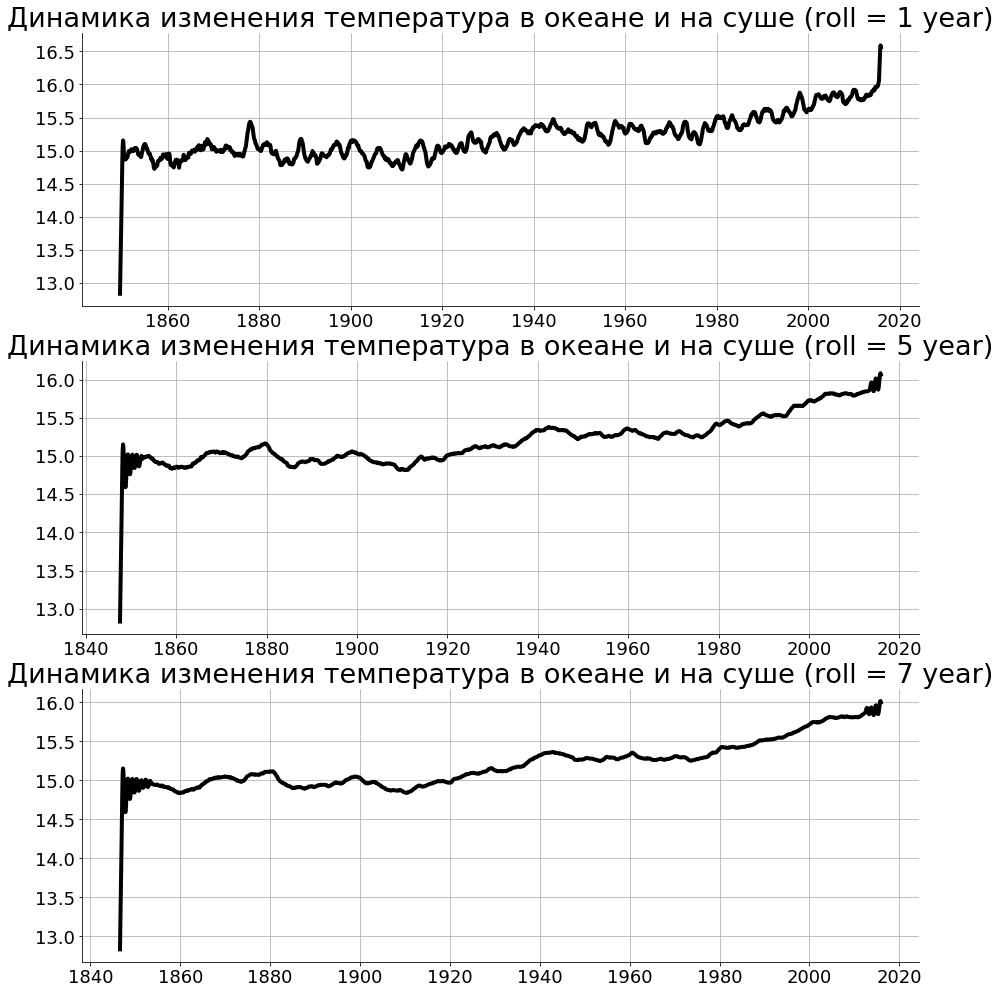

In [208]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(top=1.2)
ax = plt.subplot(311)
fontsize = 18
roll_step = 12


x = temperature['dt']
y = temperature['LandAndOceanAverageTemperature'].rolling(roll_step, min_periods=1, center=True).mean()
plt.plot(x, y, linewidth=4, color='k')
plt.title('Динамика изменения температура в океане и на суше (roll = 1 year)', fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = plt.subplot(312)
y = temperature['LandAndOceanAverageTemperature'].rolling(roll_step * 5, min_periods=1, center=True).mean()
plt.plot(x, y, linewidth=4, color='k')
plt.title('Динамика изменения температура в океане и на суше (roll = 5 year)', fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = plt.subplot(313)
y = temperature['LandAndOceanAverageTemperature'].rolling(roll_step * 7, min_periods=1, center=True).mean()
plt.plot(x, y, linewidth=4, color='k')
plt.title('Динамика изменения температура в океане и на суше (roll = 7 year)', fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [497]:
def plot_mean_temperature(roll_step, ax, column='LandAverageTemperature', title='Динамика изменения температура на суше'):
    fontsize = 28
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                  '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                  '#bcbd22', '#17becf', '#e377c2', 'k']
    month_name = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декарбрь']
    for month in range(12):
        mask = temperature['dt'].apply(lambda row: row.month == month + 1)
        x = temperature[mask]['dt']
        y = temperature[mask][column].rolling(roll_step, min_periods=1, center=True).mean()
        plt.plot(x, y, linewidth=4, color=colors[month])
        plt.text(x.iloc[-1], y.iloc[-1], month_name[month], fontsize=fontsize, color=colors[month])
    plt.title(title + ' (roll = %d)' % roll_step, fontsize=fontsize*1.5)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

Рассматривая графики динамики изменения температуры на суше по месяцам, можно сделать несколько замечаний. Во-первых, месяц декабрь в ряде случаев запаздывает или догоняет январь и февраль. Это, очевидно, связано с цикличностью летоисчисления. 

Также стоит отметить, что месяцы практически симметрично делятся на 5 групп:

* 3 группы на осень -- весну (по месяцу), причём осень в среднем оказывается теплее. Но связано это, скорее всего не с тем, что она, действительно, теплее, а стем, что в южное полушарие обладает меньшей долей суши, по сравнению с северным. Если взглянуть на среднюю температуру для океана и суши вместе взятые, то окажется, что зазор между соответствующими графиками меньше, что косвенно подтверждает гипотезу
* 2 группы на лето и зиму

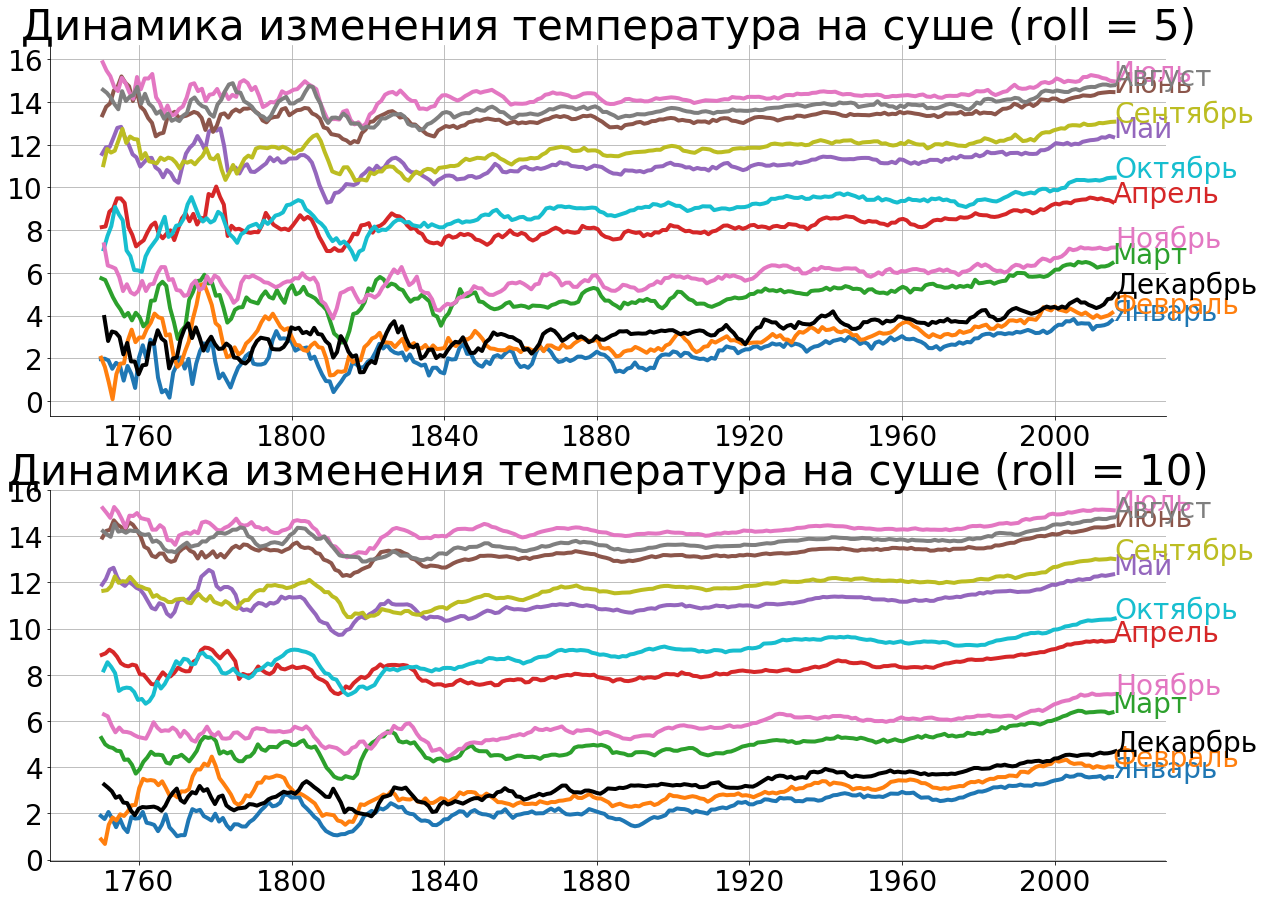

In [498]:
plt.figure(figsize=(20, 15))
ax = plt.subplot(211)
plot_mean_temperature(5, ax)

ax = plt.subplot(212)
plot_mean_temperature(10, ax)

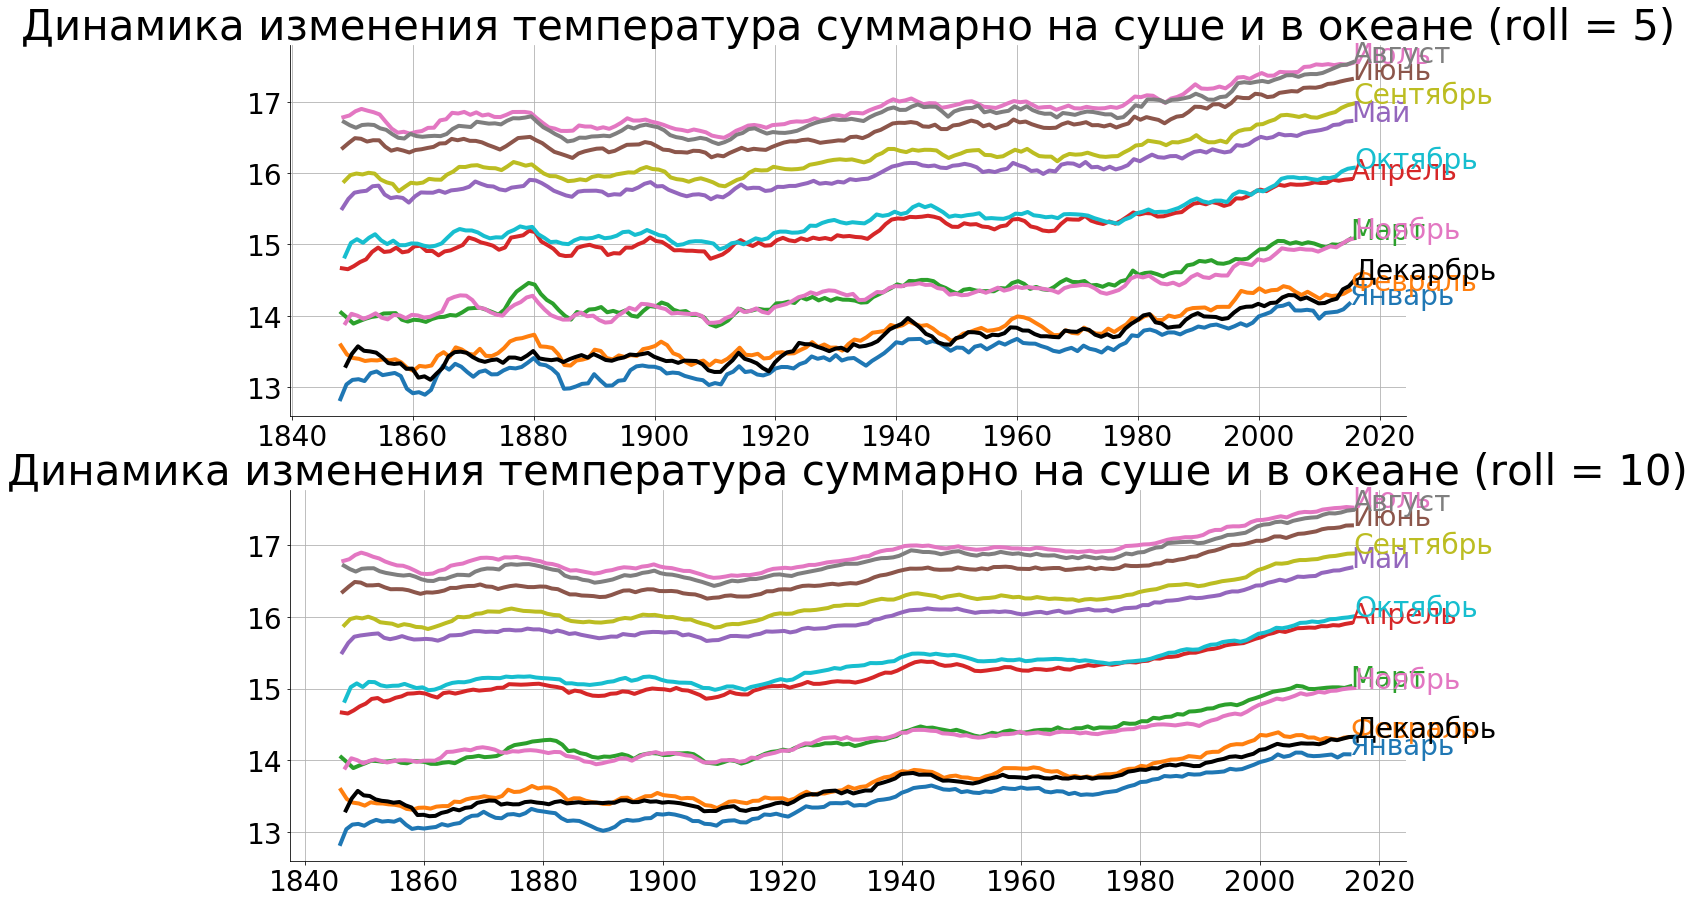

In [499]:
plt.figure(figsize=(20, 15))
ax = plt.subplot(211)
plot_mean_temperature(5, ax, 'LandAndOceanAverageTemperature', title='Динамика изменения температура суммарно на суше и в океане')

ax = plt.subplot(212)
plot_mean_temperature(10, ax, 'LandAndOceanAverageTemperature', title='Динамика изменения температура суммарно на суше и в океане')

К вопросу о точности измерений, стоит сказать, что при увеличении года, точность возрастает:

In [ ]:
month_num = 2
city_name = list(city_metrics[city_metrics['mean_less_quantile'] > 1.1].index)[10]
filtered = city[city['City'] == city_names]
filtered = filtered[filtered['dt'].apply(lambda row: row.month) == month_num].dropna()
plt.plot(filtered['dt'][filtered['City'] == city_name], filtered['AverageTemperatureUncertainty'][filtered['City'] == city_name], 'ko');

In [392]:
quantile = 0.95
stats = []
for month_num in range(1, 13):
    count = {}
    sigma = {}
    mean = {}
    filtered_month = city[city['dt'].apply(lambda row: row.month) == month_num].dropna()
    for city_name in tqdm_notebook(cities_names):
        filtered_city = filtered_month[filtered_month['City'] == city_name]
        quantile_val = filtered_city['AverageTemperatureUncertainty'].quantile(quantile)
        less_quantile = filtered_city[filtered_city['AverageTemperatureUncertainty'] < quantile_val]
        count[city_name] = less_quantile['AverageTemperatureUncertainty'].count()
        sigma[city_name] = np.sqrt(less_quantile['AverageTemperatureUncertainty'].var())
        mean[city_name] = less_quantile['AverageTemperatureUncertainty'].mean()
    stats.append({
        'count': count,
        'sigma': sigma,
        'mean': mean,
    })

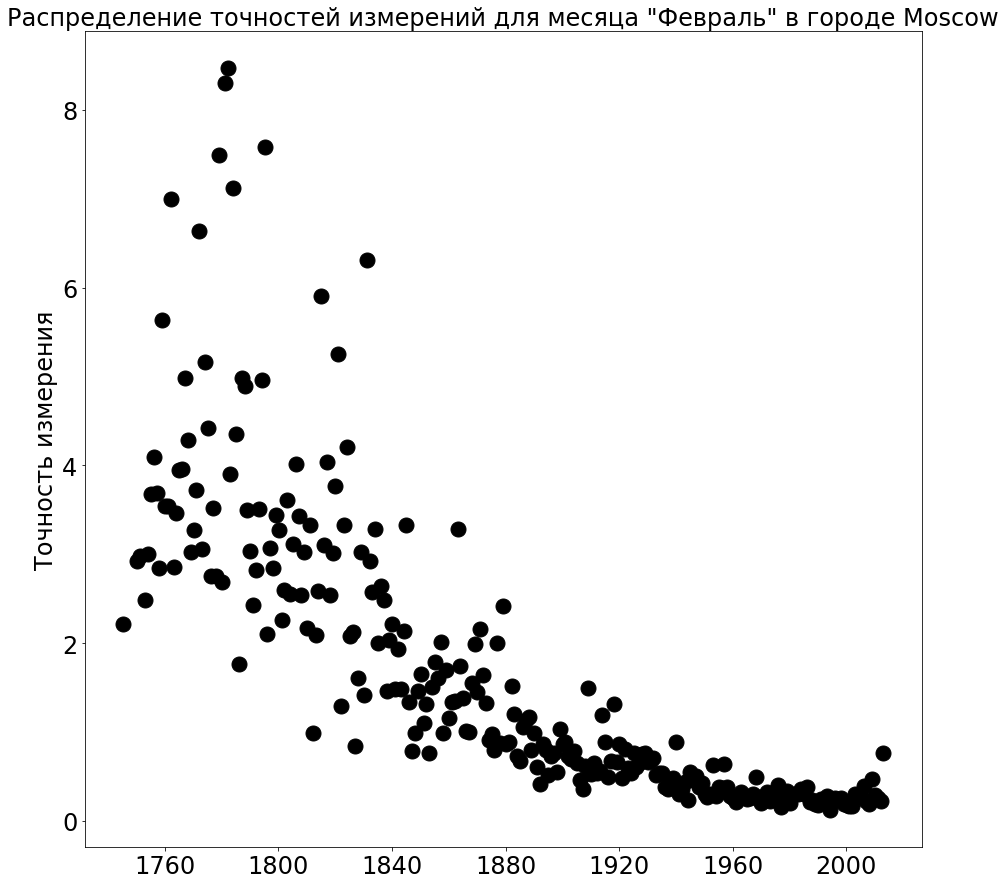

In [514]:
month_name = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декарбрь']

month_num = 2
city_name = 'Moscow'# cities_names[5]
filtered = city[city['City'] == city_name]
filtered = filtered[filtered['dt'].apply(lambda row: row.month) == month_num].dropna()
fontsize = 24
plt.figure(figsize=(15, 15))
plt.plot(filtered['dt'][filtered['City'] == city_name], filtered['AverageTemperatureUncertainty'][filtered['City'] == city_name], 'ko', markersize=15);
plt.title('Распределение точностей измерений для месяца "%s" в городе %s' % (month_name[month_num - 1], city_name), fontsize=fontsize)
plt.ylabel('Точность измерения', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize);

In [521]:
city_metrics = city_coords.copy(deep=True)
month_number = 7
city_metrics['count_quantile'] = [value[1] for value in sorted(list(stats[month_number-1]['count'].items()), key=lambda x: x[0])]
city_metrics['sigma_quantile'] = [value[1] for value in sorted(list(stats[month_number-1]['sigma'].items()), key=lambda x: x[0])]
city_metrics['mean_quantile'] = [value[1] for value in sorted(list(stats[month_number-1]['mean'].items()), key=lambda x: x[0])]

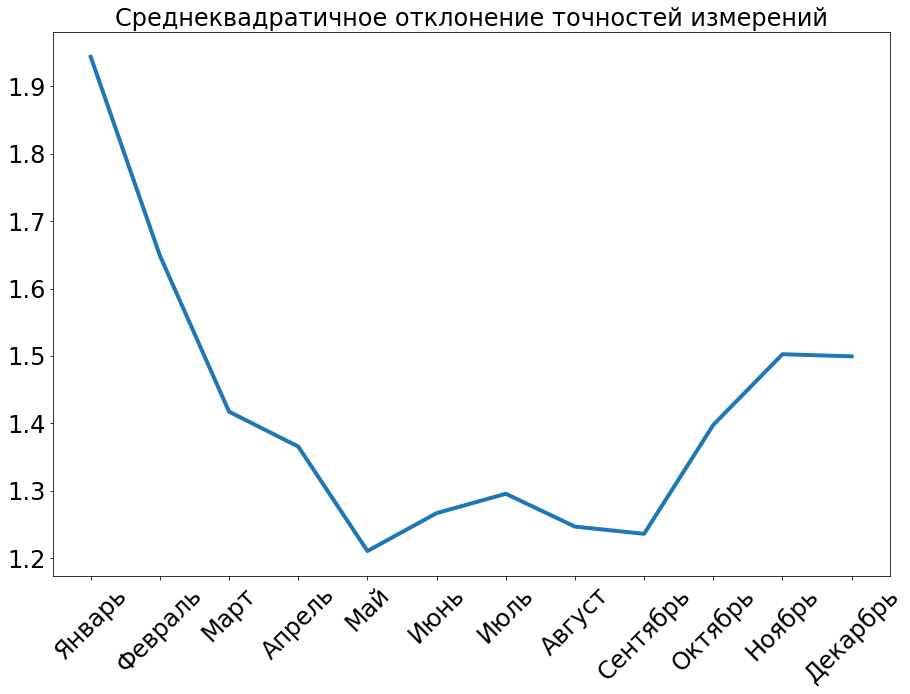

In [517]:
max_sigma = []
for month_number in range(1, 13):
    max_sigma.append(max([value[1] for value in sorted(list(stats[month_number-1]['sigma'].items()), key=lambda x: x[0])]))

month_name = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декарбрь']
plt.figure(figsize=(15, 10))
plt.plot(month_name, max_sigma, linewidth=4)
plt.xticks(rotation=45)
plt.title('Среднеквадратичное отклонение точностей измерений', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize);

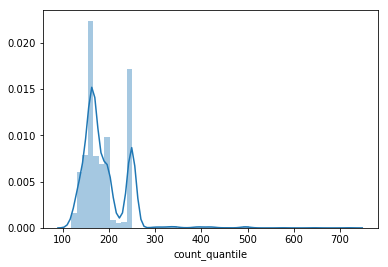

In [443]:
sns.distplot(city_metrics['count_quantile'], bins=50)

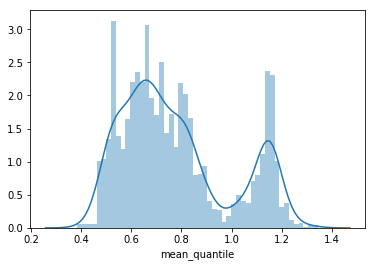

In [444]:
sns.distplot(city_metrics['mean_quantile'], bins=50)

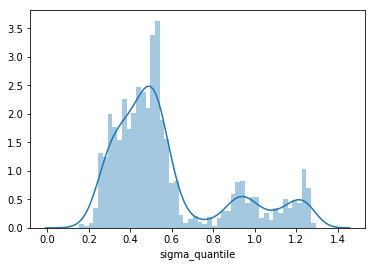

In [445]:
sns.distplot(city_metrics['sigma_quantile'], bins=50)

In [527]:
col = 'sigma_quantile'
data = [ dict(
        type = 'scattergeo',
        lon = city_metrics['lon'],
        lat = city_metrics['lat'],
        text = city_metrics.index,
        mode = 'markers',
        marker = dict(
            size = 5,
            reversescale = False,
            autocolorscale = False,
            symbol = 'circle',
            color = city_metrics['sigma_quantile'],
            cmax = city_metrics[col].max(),
            cmin = city_metrics[col].min(),
            colorbar=dict(title="Величина отклонения")
        ))]

layout = dict(
        title = 'Среднеквадратичное отклонение точностей измерений температуры в июле',
    )


fig = dict(data=data, layout=layout)
py.iplot(fig)

In [529]:
data = [ dict(
        type = 'choropleth',
        locations = country_names,
        z = percents_nan,
        locationmode = 'country names',
        text = country_names,
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = 'Average Temperature, °C')
            )
       ]

layout = dict(
    title = 'Доля неизвестных записей для температур',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        type = 'equirectangular',
#         projection = dict(
#             type = 'orthographic',
#             rotation = dict(
#                     lon = 60,
#                     lat = 10),
#         ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False)

In [532]:
roll_step = 30
month_num = 5

def roll_temperature(data, filter_name, month_num, roll_step, column_name='Country', isTwoSide=True, draw=False, is_remove_mean=False, new_fig=True):
    filtered = data[data[column_name] == filter_name]
    filtered = filtered[filtered['dt'].apply(lambda row: row.month) == month_num].dropna()
    y = filtered[filtered['dt'].apply(lambda row: row.month) == month_num]['AverageTemperature'].rolling(roll_step, min_periods=1, center=True).min()
    if isTwoSide:
        y[:2*roll_step] = filtered[filtered['dt'].apply(lambda row: row.month) == month_num]['AverageTemperature'][::-1].rolling(roll_step, min_periods=1, center=True).min()[::-1][:2*roll_step]
    x = filtered['dt'].values
    y = y.values
    if is_remove_mean:
        y -= np.mean(y)
    if draw and new_fig:
        plt.figure(figsize=(15, 10))
    if draw:
        plt.plot(x, y)
    return x, y

In [533]:
   
country_time_series = pd.DataFrame(index=country_names)
country_time_series['time_series'] = None
for country_ in tqdm_notebook(country_names):
    _, country_y = roll_temperature(country, country_, month_num, roll_step, is_remove_mean=True)
    country_time_series.at[country_, 'time_series'] = country_y

In [534]:
def partial_norm(x, y, aggfunc, roll=50):
    x = x[:min(y.shape[0], x.shape[0])]
    y = y[:min(y.shape[0], x.shape[0])]
    res = [np.inf]
    for i in range(roll, x.shape[0]):
        res.append(aggfunc(x[i-roll:i], y[i-roll:i]))
    return np.min(res)

max_norm = lambda x, y: np.max(np.abs(x[:min(y.shape[0], x.shape[0])] - y[:min(y.shape[0], x.shape[0])]))
euclid_norm = lambda x, y: np.sqrt(np.sum((x[:min(y.shape[0], x.shape[0])] - y[:min(y.shape[0], x.shape[0])]) ** 2))

In [535]:
max_norm_df = pd.DataFrame(index=country_names, columns=country_names)
euclid_norm_df = pd.DataFrame(index=country_names, columns=country_names)
partial_euclid_norm_df = {
    10: pd.DataFrame(index=country_names, columns=country_names),
    20: pd.DataFrame(index=country_names, columns=country_names),
    50: pd.DataFrame(index=country_names, columns=country_names),
    80: pd.DataFrame(index=country_names, columns=country_names),
    100: pd.DataFrame(index=country_names, columns=country_names),
    150: pd.DataFrame(index=country_names, columns=country_names),
    200: pd.DataFrame(index=country_names, columns=country_names),
}
partial_max_norm_df = {
    10: pd.DataFrame(index=country_names, columns=country_names),
    20: pd.DataFrame(index=country_names, columns=country_names),
    50: pd.DataFrame(index=country_names, columns=country_names),
    80: pd.DataFrame(index=country_names, columns=country_names),
    100: pd.DataFrame(index=country_names, columns=country_names),
    150: pd.DataFrame(index=country_names, columns=country_names),
    200: pd.DataFrame(index=country_names, columns=country_names),
}

for country_i in tqdm_notebook(country_names):
    for country_j in country_names:
        a = country_time_series.loc[country_i, 'time_series']
        b = country_time_series.loc[country_j, 'time_series']
        max_norm_df.at[country_i, country_j] = max_norm(a, b)
        euclid_norm_df.at[country_i, country_j] = euclid_norm(a, b)
        for key in partial_euclid_norm_df:
            partial_euclid_norm_df[key].at[country_i, country_j] = partial_norm(a, b, aggfunc=euclid_norm, roll=key)
        for key in partial_max_norm_df:
            partial_euclid_norm_df[key].at[country_i, country_j] = partial_norm(a, b, aggfunc=max_norm, roll=key)

Далее не отлаженный код

In [ ]:
i0, i1, t0, t1 = 0, 242, 0.015, 0.016
df_ = partial_euclid_norm_df[50]
cols, index = np.where((df_[df_.columns[i0:i1]].iloc[i0:i1] < t1) & (df_[df_.columns[i0:i1]].iloc[i0:i1] > t0) & (~df_[df_.columns[i0:i1]].iloc[i0:i1].isnull()) & (df_[df_.columns[i0:i1]].iloc[i0:i1] > 0) )
sns.heatmap(df_[df_.columns[cols]].iloc[index].astype(float))

0.26496551724137873

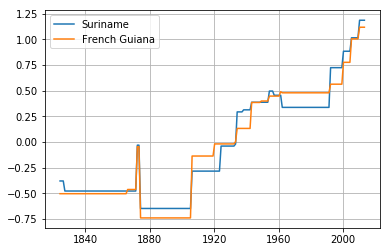

In [537]:
c0 = 'Suriname'
c1 = 'French Guiana'
roll_temperature(country, c0, month_num, roll_step, draw=True, is_remove_mean=True, new_fig=False);
roll_temperature(country, c1, month_num, roll_step, draw=True, is_remove_mean=True, new_fig=False);
plt.legend([c0, c1])
plt.grid(True)

a = country_time_series.loc[c0, 'time_series']
b = country_time_series.loc[c1, 'time_series']
partial_norm(a, b, aggfunc=max_norm, roll=100)

In [305]:
i0, i1, t0, t1 = 0, 242, 0.015, 0.016
df_ = partial_euclid_norm_df[50]
cols, index = np.where((df_[df_.columns[i0:i1]].iloc[i0:i1] < t1) & (df_[df_.columns[i0:i1]].iloc[i0:i1] > t0) & (~df_[df_.columns[i0:i1]].iloc[i0:i1].isnull()) & (df_[df_.columns[i0:i1]].iloc[i0:i1] > 0) )
best_pairs = list(zip(list(df_.columns[cols]), list(df_.index[index])))
for ind, best_pair in enumerate(best_pairs):
    if best_pair[0] > best_pair[1]:
        best_pairs[ind] = (best_pair[1], best_pair[0])
np.unique(sorted(best_pairs, key=lambda x: x[0] + x[1]), axis=0)

array([['Anguilla', 'Saint Kitts And Nevis'],
       ['Dominica', 'Guadeloupe'],
       ['Dominica', 'Saint Lucia'],
       ['French Guiana', 'Suriname'],
       ['Guadeloupe', 'Martinique'],
       ['Martinique', 'Saint Lucia'],
       ['Saint Barthélemy', 'Saint Kitts And Nevis'],
       ['Saint Kitts And Nevis', 'Saint Martin'],
       ['Saint Kitts And Nevis', 'Sint Maarten']], dtype='<U21')

In [38]:
df_flight_paths = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_aa_flight_paths.csv')
df_airports = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')

airports = [ dict(
        type = 'scattergeo',
        locationmode = 'country names',
        lon = df_airports['long'],
        lat = df_airports['lat'],
        hoverinfo = 'text',
        text = df_airports['airport'],
        mode = 'markers',
        marker = dict( 
            size=2, 
            color='rgb(255, 0, 0)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ))]
        
flight_paths = []
for i in range( len( df_flight_paths ) ):
    flight_paths.append(
        dict(
            type = 'scattergeo',
            locationmode = 'country names',
            lon = [ df_flight_paths['start_lon'][i], df_flight_paths['end_lon'][i] ],
            lat = [ df_flight_paths['start_lat'][i], df_flight_paths['end_lat'][i] ],
            mode = 'lines',
            line = dict(
                width = 1,
                color = 'red',
            ),
            opacity = float(df_flight_paths['cnt'][i])/float(df_flight_paths['cnt'].max()),
        )
    )
    
layout = dict(
        title = 'Feb. 2011 American Airline flight paths<br>(Hover for airport names)',
        showlegend = False, 
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict( data=flight_paths + airports, layout=layout )
py.iplot( fig, filename='d3-flight-paths' )

In [370]:
mask = (city['dt'] >= datetime(year=1860, month=1, day=1)) & \
(city['Country'] == 'Russia') & \
(city['AverageTemperature'] > 10) & (city['AverageTemperatureUncertainty'] > 5) & \
(city['AverageTemperature'] > 18)

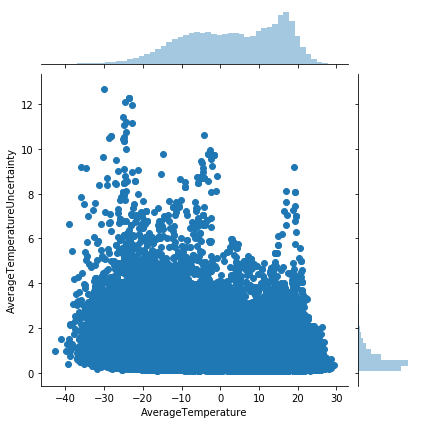

In [371]:
x = city[mask]['AverageTemperature']
y = city[mask]['AverageTemperatureUncertainty']
sns.jointplot(city[mask]['AverageTemperature'], city[mask]['AverageTemperatureUncertainty'])

In [375]:
mask = (city['dt'] >= datetime(year=1860, month=1, day=1)) & \
(city['Country'] == 'Russia') & \
(city['AverageTemperature'] > 10) & (city['AverageTemperatureUncertainty'] > 5)

lats = []
lons = []
for city_ in city[mask]['City'].unique():
    lats.append(city_coords[city_coords.index == city_]['lat'].iloc[0])
    lons.append(city_coords[city_coords.index == city_]['lon'].iloc[0])

In [373]:
col = 'mean_less_quantile'
data = [ dict(
        type = 'scattergeo',
        lon = lons,
        lat = lats,
        text = c.index,
        mode = 'markers',
        marker = dict(
            size = 5,
            reversescale = False,
            autocolorscale = False,
            symbol = 'circle'
        ))]

layout = dict(
        title = 'Count noised points',
        colorbar = True,
        geo = dict(
            type = 'equirectangular',
        ),
    )


fig = dict( data=data)
py.iplot( fig)

ValueError: x and y must have same first dimension, but have shapes (716966,) and (158,)

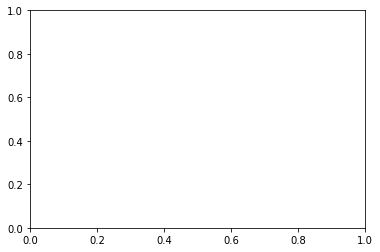

In [410]:
january = city[city['dt'].apply(lambda row: row.month == 1)]
july = city[city['dt'].apply(lambda row: row.month == 7)]
year = january['dt'].apply(lambda row: row.year)
delta = np.abs(january[january['City'] == city_]['AverageTemperature'].values - july[july['City'] == city_]['AverageTemperature'].values)
plt.plot(year, delta)

In [409]:
for city_ in tqdm_notebook(cities_names):
    year = january['dt'].apply(lambda row: row.year)
    delta = np.abs(january[january['City'] == city_]['AverageTemperature'].values - july[july['City'] == city_]['AverageTemperature'].values)

KeyboardInterrupt: 